In [1]:
import os
import shutil

import csv
import pandas as pd
import tensorflow as tf
import numpy as np
import tensorflow_hub as hub
# import tensorflow_text as text
import keras

from keras import Input
from keras.layers import TextVectorization
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import (
    GRU,
    Conv1D,
    Dense,
    Embedding,
    Flatten,
    Lambda,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

#confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn



print(tf.__version__)

2023-02-16 16:44:23.016909: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-16 16:44:23.851454: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-02-16 16:44:23.851548: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

2.11.0


In [2]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

2023-02-16 16:44:26.833043: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-16 16:44:26.846097: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-16 16:44:26.847942: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-16 16:44:26.850430: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [3]:
#read data
# data = pd.read_csv("../data/patent_rand100k.csv")
# data = pd.read_csv("../data/patent_evan-100K.csv")#, quoting=csv.QUOTE_NONE, encoding='utf-8')
url = 'https://drive.google.com/file/d/16iYEWb1xCiuR5_TM47RVZyzLFwD7gZnT/view?usp=share_link'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df = pd.read_csv(path)
#shuffle data
# data = df.sample(frac=1)

In [13]:
# # data.groupby('ipc_section').count()

dataSort = df.query('(ipc_section == "A")').sample(n=2250)
dataSort = pd.concat([dataSort,df.query('(ipc_section == "B")').sample(n=1250)])
dataSort = pd.concat([dataSort,df.query('(ipc_section == "C")').sample(n=2250)])
dataSort = pd.concat([dataSort,df.query('(ipc_section == "D")').sample(n=1250)])
dataSort = pd.concat([dataSort,df.query('(ipc_section == "E")').sample(n=1250)])
dataSort = pd.concat([dataSort,df.query('(ipc_section == "F")').sample(n=1250)])
dataSort = pd.concat([dataSort,df.query('(ipc_section == "G")').sample(n=1250)])
dataSort = pd.concat([dataSort,df.query('(ipc_section == "H")').sample(n=1250)])
# data=data.sample(50000)
data = dataSort.sample(frac=1)

In [14]:
# data = pd.read_csv("../data/patent-10k_balanced.csv")
# data = data.sample(frac=1)

In [15]:
data.groupby('ipc_section').count()

,application_number,kind_code,application_kind,family_id,language,title,abstract,ipc_code,ipc_class,ipc_code_sub_class
ipc_section,,,,,,,,,,
A,2250,2250,2250,2250,2250,2250,2250,2250,2250,2250
B,1250,1250,1250,1250,1250,1250,1250,1250,1250,1250
C,2250,2250,2250,2250,2250,2250,2250,2250,2250,2250
D,1250,1250,1250,1250,1250,1250,1250,1250,1250,1250
E,1250,1250,1250,1250,1250,1250,1250,1250,1250,1250
F,1250,1250,1250,1250,1250,1250,1250,1250,1250,1250
G,1250,1250,1250,1250,1250,1250,1250,1250,1250,1250
H,1250,1250,1250,1250,1250,1250,1250,1250,1250,1250


In [16]:
len(data)

12000

In [17]:
#one hot encode target
# classes = [[0,1,2,3,4,5,6,7][source] for source in dataSort.ipc_section]
classes = [{"A":0,"B":1,"C":2,"D":3,"E":4,"F":5,"G":6,"H":7}[source] for source in data.ipc_section]
target = to_categorical(classes)
#print target
# target[2002]
len(target)

12000

In [18]:
BATCHSIZE = 10

inputs = Input(shape=(512,),dtype=tf.float32,name="InputString")
# x = Dense(256,activation="relu")(inputs)
x = Dense(512,activation="relu",kernel_regularizer=tf.keras.regularizers.L2(0.005))(inputs)
# x = Dense(512,activation="relu")(inputs)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = Dense(8,activation="softmax")(x)

model = keras.Model(inputs=inputs,outputs=outputs,name="modeltest")
model.summary()
model.compile(optimizer="adam", loss="categorical_crossentropy",metrics=["Accuracy"])

Model: "modeltest"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputString (InputLayer)    [(None, 512)]             0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 266,760
Trainable params: 266,760
Non-trainable params: 0
_________________________________________________________________


In [19]:
modelhistory = model.fit(
    embed(data.abstract),
    target, 
    epochs=20,
    batch_size=BATCHSIZE, 
    validation_split=0.2
    # validation_data=(data.text[6000:],target[6000:]),
    # callbacks=[EarlyStopping(patience=10)]
)

Epoch 1/20
960/960 [==============================] - 3s 3ms/step - loss: 1.7135 - Accuracy: 0.4998 - val_loss: 1.5086 - val_Accuracy: 0.5304
Epoch 2/20
960/960 [==============================] - 3s 3ms/step - loss: 1.4920 - Accuracy: 0.5387 - val_loss: 1.4617 - val_Accuracy: 0.5529
Epoch 3/20
960/960 [==============================] - 3s 3ms/step - loss: 1.4681 - Accuracy: 0.5504 - val_loss: 1.4641 - val_Accuracy: 0.5425
Epoch 4/20
960/960 [==============================] - 3s 3ms/step - loss: 1.4571 - Accuracy: 0.5462 - val_loss: 1.4565 - val_Accuracy: 0.5421
Epoch 5/20
960/960 [==============================] - 3s 3ms/step - loss: 1.4439 - Accuracy: 0.5495 - val_loss: 1.4847 - val_Accuracy: 0.5233
Epoch 6/20
960/960 [==============================] - 3s 3ms/step - loss: 1.4388 - Accuracy: 0.5591 - val_loss: 1.4356 - val_Accuracy: 0.5487
Epoch 7/20
960/960 [==============================] - 3s 3ms/step - loss: 1.4450 - Accuracy: 0.5507 - val_loss: 1.4588 - val_Accuracy: 0.5375
Epoch 

<AxesSubplot:title={'center':'BS=10 | USE | 0.2 DO| 256 dense'}>

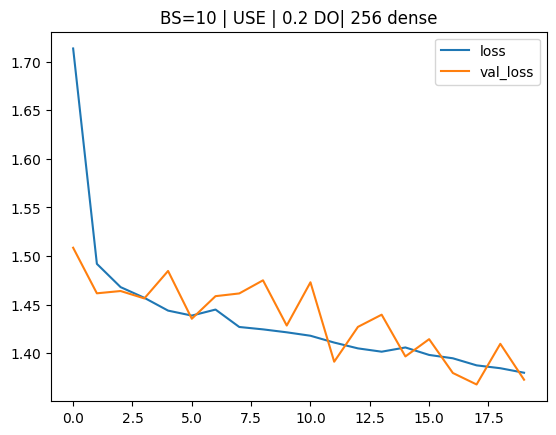

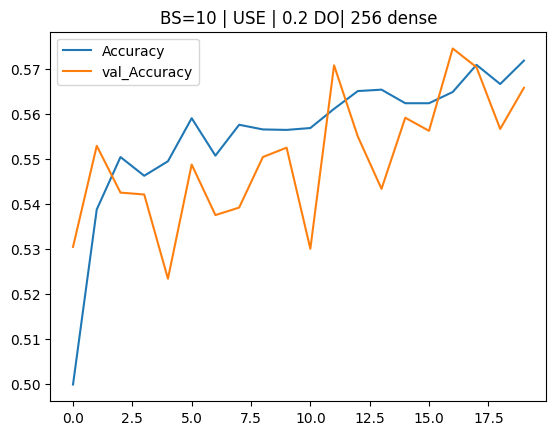

In [20]:
pd.DataFrame(modelhistory.history)[["loss","val_loss"]].plot(title="BS="+ str(BATCHSIZE) +" | USE | 0.2 DO| 256 dense")
pd.DataFrame(modelhistory.history)[["Accuracy","val_Accuracy"]].plot(title="BS="+ str(BATCHSIZE) +" | USE | 0.2 DO| 256 dense")

Text(0.5, 1.0, 'Confusion Matrix')

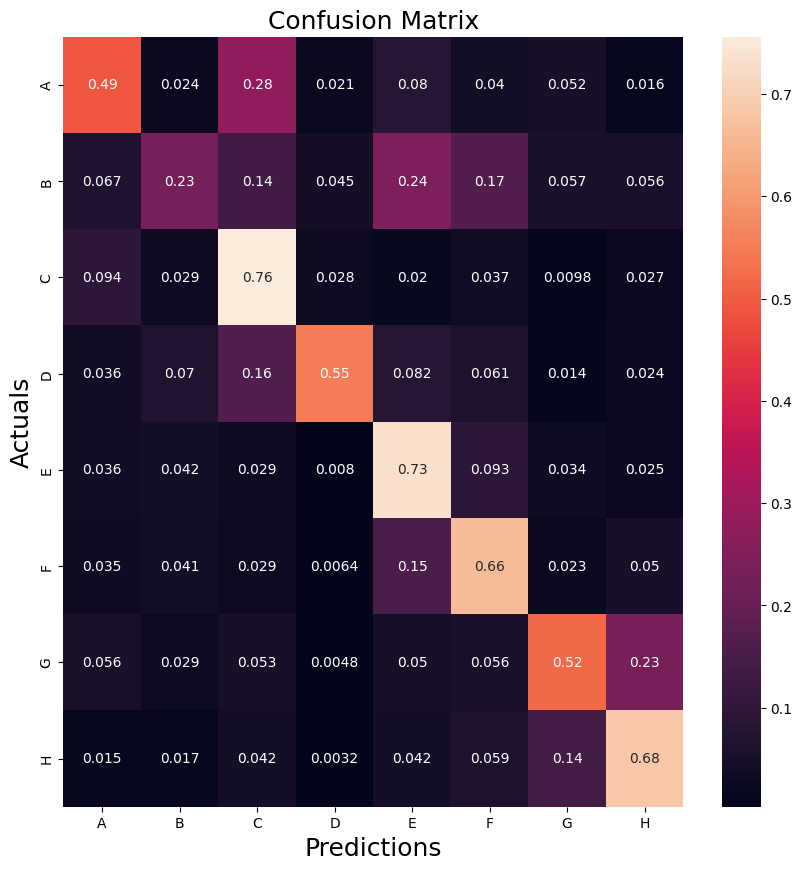

In [21]:
yhat_probs = model.predict(embed(data.abstract), verbose=0)
yhat_classes = np.argmax(yhat_probs, axis=1)
y_test_classes = np.argmax(target, axis=1)
matrix = confusion_matrix(y_test_classes, yhat_classes, normalize="true")
df_cm = pd.DataFrame(matrix, index = [i for i in "ABCDEFGH"],
                     columns = [i for i in "ABCDEFGH"])
plt.figure(figsize = (10,10))
sn.heatmap(df_cm, annot=True)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)